# Description
We tried to reproduce the experiments from the paper  **"Learning Pruning-Friendly Networks via Frank-Wolfe: One-Shot, Any-
Sparsity, And No Retraining"*, conducted with Res-Net-18 and VCG-
16 on the datasets CIFAR-10 and TinyImageNet. 
  The running of
the entire model performed by the paper’s authors would take hundreds of hours, which was
obviously not empirically doable in our case.
Therefore we did implement a simplified version of it, with our own model. Our results are obviously much worse in terms of accuracy, but serve well the purpose of comparing results between optimizers.

# Libraries
Before starting, we implement all necessary libraries.

In [1]:
"""    Importing libraries """

#numerical libraries

import numpy as np
from numpy import vstack
from numpy import argmax
import math

#torch libraries
import torch
from torchvision import datasets, transforms
import torch.nn.utils.prune as prune
import torch.nn.functional as F 
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD

#dataset libraries
from torchvision import datasets, transforms
from tensorflow.keras import models,layers
import pandas as pd

#Plotting libraries
import matplotlib.pyplot as plt

# Evaluation libraries
import os
import time
import logging
import argparse
from sklearn.metrics import accuracy_score

# Loading Datasets

On both datasets we used data augmenta-
tion techniques so that our models generalize
better. Moreover, all images have been re-scaled
and normalized, in order to reduce data skew-
ness.

**CIFAR10** is a dataset of 50,000 32x32 color
training images and 10,000 test images, labeled
over 10 (mutually exclusive) categories. They
were collected by Alex Krizhevsky, Vinod Nair,
and Geoffrey Hinton.



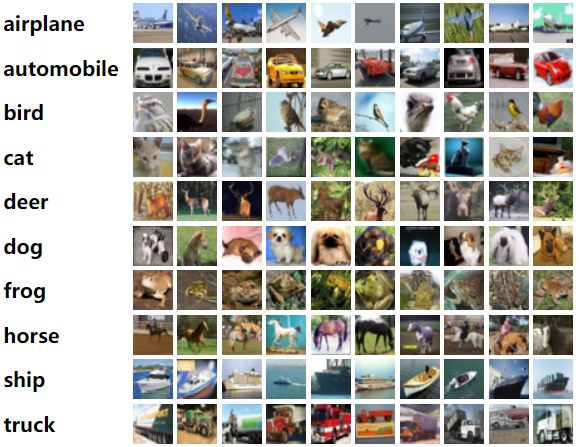

In [2]:
#first we define a loading function
def load_cifar10_data(dir_path, train_batchsize, test_batchsize):
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = datasets.CIFAR10(root=dir_path + '/data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batchsize, shuffle=True)

    testset = datasets.CIFAR10(root=dir_path + '/data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batchsize, shuffle=False)
    return trainloader, testloader

# now we actually load the already processed dataset
dir_path = os.getcwd() 

train_data, test_data = load_cifar10_data(dir_path, 128, 128)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


**Tiny ImageNet** is a smaller version of The
ImageNet Large Scale Visual Recognition Chal-
lenge(ILSVRC). It has 64x64 images,
split into 200 classes, with a training dataset of
100k images, a validation dataset of 10k images,
and a test dataset of 10k images.



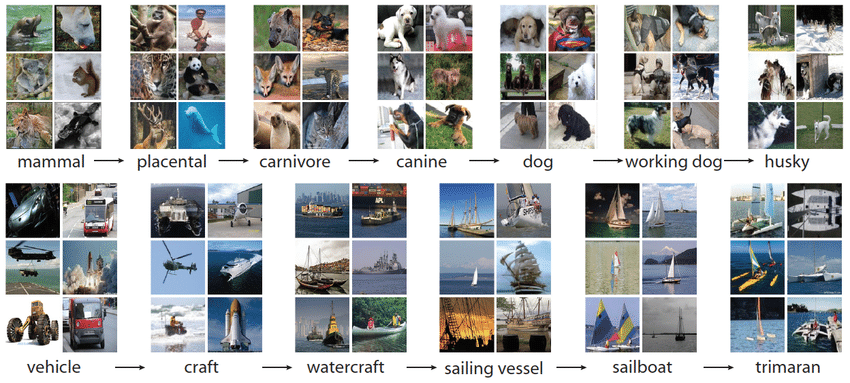

In [3]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 16.70 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Updating files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


In [4]:
def load_tiny_imagenet_data(dir_path, train_batchsize, test_batchsize, dataset=False, split_file=None):  #loading function

    train_transform = transforms.Compose([
        transforms.RandomCrop(64, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_path = dir_path + '/data/tiny_imagenet_200/train'
    val_path = dir_path + '/data/tiny_imagenet_200/test'

    if not split_file:
        split_file = dir_path + '/data/tiny_imagenet_200/npy_files/tiny-imagenet-train-val.npy'
    split_permutation = list(np.load(split_file))

    train_set = torch.utils.data.Subset(datasets.ImageFolder(train_path, transform=train_transform), split_permutation[:90000])
    val_set = torch.utils.data.Subset(datasets.ImageFolder(train_path, transform=test_transform), split_permutation[90000:])
    test_set = datasets.ImageFolder(val_path, transform=test_transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batchsize, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=train_batchsize, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batchsize, shuffle=False, num_workers=2, pin_memory=True)

    if dataset:
        print('return train dataset')
        train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
        return train_dataset, val_loader, test_loader
    else:
        return train_loader, val_loader, test_loader


def tiny_loader(dir_path, train_batchsize, test_batchsize):
    num_label = 200
    normalize = transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821))
    transform_train = transforms.Compose(
        [transforms.RandomResizedCrop(32), transforms.RandomHorizontalFlip(), transforms.ToTensor(),
         normalize, ])
    transform_test = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), normalize, ])
    trainset = datasets.ImageFolder(root=dir_path + '/train', transform=transform_train)
    testset = datasets.ImageFolder(root=dir_path + '/val', transform=transform_test)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batchsize, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batchsize, shuffle=False)
    
    return train_loader, test_loader

dir_path = '/content/IMagenet'

train_data1, test_data1 = tiny_loader(
            dir_path + '/tiny-imagenet-200', 1, 1)

# Weight initialization function



In [5]:
# Set a tolerance value
tolerance = 1e-10

# Function to calculate the average initial norm
@torch.no_grad()
def get_avg_init_norm(layer, param_type=None, ord=2, iter=100):
    # Initialize the output to 0
    output = 0

    # Loop through the number of iterations
    for i in range(iter):
        # Reset the parameters of the layer
        layer.reset_parameters()
        
        # Calculate the norm of the given parameter type
        # using the given order (ord)
        # and add it to the output
        output += torch.norm(getattr(layer, param_type), p=ord).item()

    # Return the average of the norms calculated in each iteration
    return float(output) / iter

# Constraint classes

In [6]:
class Constraint:

    # Initialize the constraint with the number of dimensions
    def __init__(self, n):
        # Set the diameter and radius to None by default
        self.diameter = None
        self.radius = None

        # Store the number of dimensions
        self.n = n

    # Check if the constraint is unconstrained
    def is_unconstrained(self):
        return False

    # Return the diameter of the constraint
    def get_diameter(self):
        return self.diameter

    # Return the radius of the constraint
    def get_radius(self):
        try:
            return self.radius
        except:
            # Raise an error if the radius is not defined
            raise ValueError("No radius constraint")

    # Perform the LMO (Linear Minimal Optimization) operation
    def lmo(self, x):
        # Check that the input x has the correct number of dimensions
        assert x.numel() == self.n, f"Shape {x.shape} doesn't match dimension {self.n}"

    # Shift the input x inside the constraint
    def shift_inside(self, x):
        # Check that the input x has the correct number of dimensions
        assert x.numel() == self.n, f"Shape {x.shape} doesn't match dimension {self.n}"

    # Perform the Euclidean projection of the input x onto the constraint
    def euclidean_project(self, x):
        # Check that the input x has the correct number of dimensions
        assert x.numel() == self.n, f"Shape {x.shape} doesn't match dimension {self.n}"

In [7]:
class KSparsePolytope(Constraint):
    # Initialize the constraint with the number of elements in the parameter tensor, K and either the diameter or radius of the polytope
    def __init__(self, n, K=1, diam=None, rad=None):
        super().__init__(n)

        # Store the value of K and make sure that it's not greater than the number of elements in the tensor
        self.k = min(K, n)
        
        # If the diameter is provided, calculate the radius and vice versa
        if diam is None:
            self.radius = rad
            self.diameter = 2.0 * rad * math.sqrt(self.k)
        if rad is None:
            self.radius = diam / (2.0 * math.sqrt(self.k))
            self.diameter = diam
        else:
            # If neither the radius or the diameter is provided, raise an error
            raise ValueError("Give just one of Radius or Diameter")

    @torch.no_grad()
    def lmo(self, x):
        # Call the parent's lmo method
        super().lmo(x)

        # Create a zero tensor with the same shape as the input tensor
        v = torch.zeros_like(x)
        
        # Find the indices of the k largest absolute values in the flattened input tensor
        maxIndices = torch.topk(torch.abs(x.flatten()), k=self.k).indices
        
        # Set the values at those indices in the output tensor to the corresponding sign of the input value multiplied by the radius
        v.view(-1)[maxIndices] = -self.radius * torch.sign(x.view(-1)[maxIndices])
        
        # Return the output tensor
        return v

At each step of our optimization, the linear
minimization oracle of a K-sparse polytope con-
straint returns a update vector with exactly K
non-zero coordinates, which is then weighted-
averaged with the current θt according to the
SFW algorithm. By adding such a constraint,
each SFW step pushes less important weights
4
smaller, enhancing the important ones. More-
over, the amounts of weights, at different mag-
nitude levels, change more smoothly, resulting
in a good weight distribution that does not
cause sudden “jump” when the pruning ratio
increases.

In [8]:
def create_k_sparse_constraints(model, K=1, K_frac=None, value=300):
    # Initialize an empty list to store the constraints
    constraints = []

    # Compute average init norms for each layer's weight and bias parameters
    init_norms = dict()
    for layer in model.modules():
        # Check if the layer has a "reset_parameters" method
        if hasattr(layer, 'reset_parameters'):
            # Check if the layer has a "weight" or "bias" attribute
            for param_type in [entry for entry in ['weight', 'bias'] if (hasattr(layer, entry) and type(getattr(layer, entry)) != type(None))]:
                param = getattr(layer, param_type)
                shape = param.shape
                # Compute the average init norm for the parameter
                avg_norm = get_avg_init_norm(layer, param_type=param_type, ord=2)
                # If the average init norm is zero, set it to 1.0
                if avg_norm == 0.0:
                    avg_norm = 1.0
                # Store the average init norm in the `init_norms` dictionary
                init_norms[shape] = avg_norm

    # For each weight and bias parameter in the model
    for name, param in model.named_parameters():
        n = param.numel()
        # Compute the number of non-zero values, `real_K`, that are allowed in the constraint
        real_K = min(max(int(K), int(K_frac * n)), n)
        # Compute the diameter of the constraint
        diameter = 2.0 * value * init_norms[param.shape]
        # Create the constraint for the parameter
        constraint = KSparsePolytope(n, K=real_K, diam=diameter, rad=None)
        # Add the constraint to the `constraints` list
        constraints.append(constraint)

    # Return the list of constraints
    return constraints


# SFW optimizer
The star of the show. The Frank-Wolfe method (otherwise known as
conditional gradient method or reduced gradient
method) is an iterative first-order optimization
algorithm. It recently regained a tremendous
popularity in machine-learning in terms of its
projection free property and ability to exploit
structured constraints. In comparison with the
Projected Gradient method, its popular alter-
native, this greatly improves the computational
aspect. In fact, the projection onto the con-
strained set (which generally requires solving a
quadratic program) is replaced with a linear op-
timization over the constrained set at each iter-
ation.

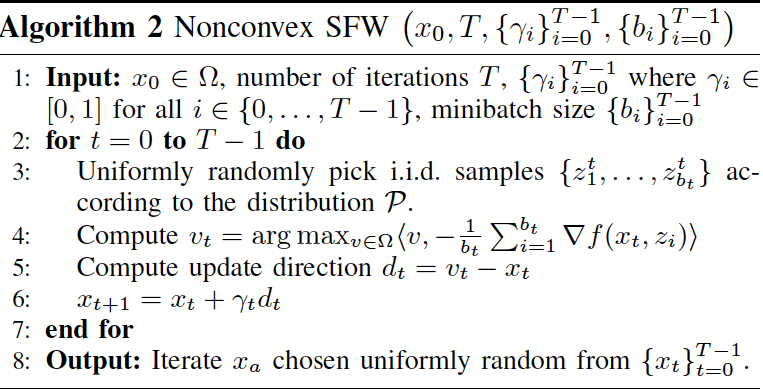

In [9]:
class SFW(torch.optim.Optimizer):
    # Initialization method for the SFW optimizer
    def __init__(self, params, learning_rate=0.1, rescale='diameter', momentum=0.9):
        # Check if learning rate is within [0, 1]
        if not (0.0 <= learning_rate <= 1.0):
            raise ValueError("Learning rate must be between [0, 1].")
        # Check if momentum is within [0, 1]
        if not (0.0 <= momentum <= 1.0):
            raise ValueError("Momentum must be between [0, 1].")
        # Check if rescale type is one of the valid options
        if not (rescale in ['diameter', 'gradient', None]):
            raise ValueError("Rescale type must be between ['diameter', 'gradient' or None].")

        # Set rescale type
        self.rescale = rescale

        # Set hyperparameters with default values
        defaults = dict(lr=learning_rate, momentum=momentum)
        super(SFW, self).__init__(params, defaults)

    # Step function that updates the parameters at each iteration
    @torch.no_grad()
    def step(self, constraints, closure=None):
        # Initialize loss
        loss = None
        # Index of current constraint
        idx = 0

        # Loop over groups of parameters
        for group in self.param_groups:
            # Loop over each parameter in the group
            for p in group['params']:
                # Skip if parameter has no gradient
                if p.grad is None:
                    continue
                # Get the gradient of the parameter
                d_p = p.grad

                # Add momentum to update
                momentum = group['momentum']
                if momentum > 0:
                    # Get the state for the current parameter
                    param_state = self.state[p]
                    # Initialize momentum buffer if it doesn't exist
                    if 'momentum_buffer' not in param_state:
                        param_state['momentum_buffer'] = d_p.detach().clone()
                    else:
                        # Update momentum buffer
                        param_state['momentum_buffer'].mul_(momentum).add_(d_p, alpha=1 - momentum)
                        d_p = param_state['momentum_buffer']

                # Compute LMO solution
                v = constraints[idx].lmo(d_p)

                # Compute rescale factor
                if self.rescale == 'diameter':
                    # Rescale by diameter
                    factor = 1. / constraints[idx].get_diameter()
                elif self.rescale == 'gradient':
                    # Rescale by gradient
                    factor = torch.norm(d_p, p=2) / torch.norm(p - v, p=2)
                else:
                    # No rescaling
                    factor = 1
                # Compute the learning rate
                lr = max(0.0, min(factor * group['lr'], 1.0))
                # Update the parameter
                p.mul_(1 - lr)
                p.add_(v, alpha=lr)

                # Increment the index to move on to the next constraint
                idx += 1

        return loss

# Implementation of architectures used in the papers

**ResNet**, or **Residual Network Models**, are
NNs that make use of skip connections in order
to reduce the typical problem of vanishing gradi-
ents, whilst speeding up the learning process. In
particular, we will be using a ResNet18 model as seen in the picture below:

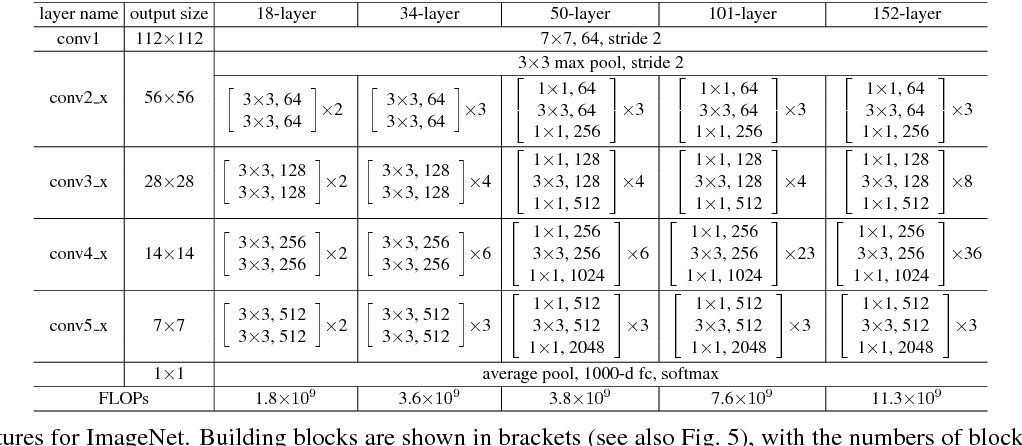

In [10]:
class BasicBlock(nn.Module): #the basic block from which any ResNet is constructed
    expansion = 1

    def __init__(self, in_planes, planes, stride=1): 
        super(BasicBlock, self).__init__() 
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):   # Now we actually define the ResNet module class
    def __init__(self, num_classes=10): 
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, stride=1)
        self.layer2 = self._make_layer(128, stride=2)
        self.layer3 = self._make_layer(256, stride=2)
        self.layer4 = self._make_layer(512, stride=2)
        
        self.classifier = nn.Linear(512*BasicBlock.expansion, num_classes)

    def _make_layer(self, planes, stride):
      # Create a list of ResNet blocks with different strides for the current layer
        strides = [stride] + [1]
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes * BasicBlock.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
      # Pass the input tensor through the network
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def get_features(self, x):
      # Get the output from the intermediate layers, before the classifier
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out


def ResNet18(num_classes=10):   #function to actually create our model
    return ResNet(num_classes = num_classes)

**VGG16 ** is a CNN that makes use of multi-
ple 3x3 convolutional stacks - it has been iden-
tified to be the best performing model on the
aforementioned ImageNet dataset at its time,
and was proposed by the Visual Geometry
Group of the university of Oxford.

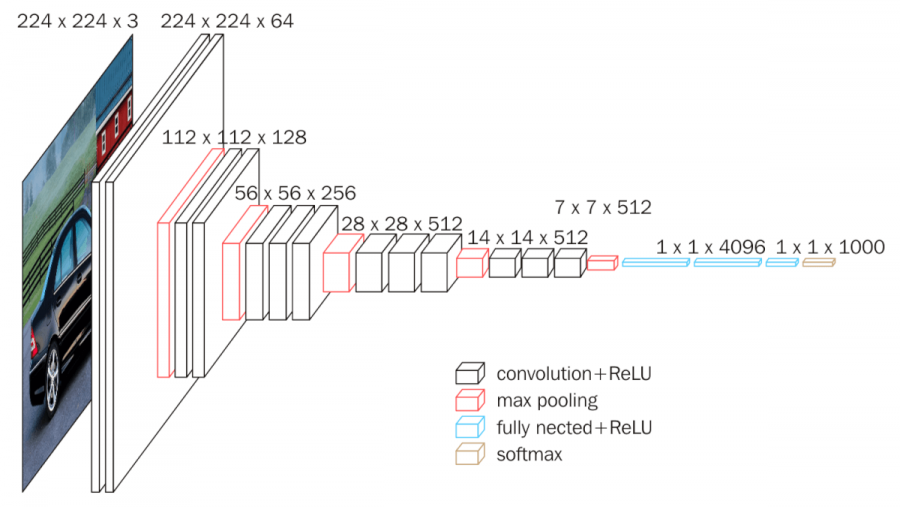

In [11]:
class VGG(nn.Module):  #We define the VGG module class

    def __init__(self, num_classes=10):
        super(VGG, self).__init__()
        self.features = self.make_layers()
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def make_layers(self):
        model = [64, 64, 'maxPool', 128, 128, 'maxPool', 256, 256, 256, 'maxPool', 512, 512, 512, 'maxPool', 512, 512, 512, 'maxPool']
        layers = []
        in_channels = 3
        for x in model:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

def VGG16(num_classes=10):   #function to actuallyu create our model
    return VGG(num_classes=num_classes)

# Our model
This more simplistic, yet less time consuming model is what we chose to compare the performance of the two optimizers in a one-shot pruning framework. It is a classic CNN with 2 Convolutional layers over 3 color channels, followed by MaxPooling layers, and 3 linear layers. The activation function for all layers is ReLu.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(nn.Module):  #define our model

  def __init__(self, num_classes):
      super(Model, self).__init__()

      self.conv1 = nn.Conv2d(3, 6, 5)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 5)
      
      self.fc1 = nn.Linear(16 * 5 * 5, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, num_classes)

  def forward(self, z):
      z = self.pool(F.relu(self.conv1(z)))
      z = self.pool(F.relu(self.conv2(z)))
      z = z.view(-1, 16 * 5 * 5)
      z = F.relu(self.fc1(z))
      z = F.relu(self.fc2(z))
      z = self.fc3(z)
      return z

In [13]:
# create a complete CNN
model = Model(10)
print(model)

Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#Model training 
Train model functions, depending on our choice of optimizers.

In [14]:
#model training for SFW

def train_model_SFW(train_dl, model, constraints_list=0):

    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = SFW(model.parameters())
    # enumerate epochs
    for epoch in range(5):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            output = model(inputs)
            # calculate loss with CrossEntropy
            loss = criterion(output, targets)
            # credit assignment
            loss.backward()
            # update model weights using constraints_list
            optimizer.step(constraints_list)


#model training for SGD
def train_model_SGD(train_dl, model):

    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(5):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            output = model(inputs)
            # calculate loss with CrossEntropy
            loss = criterion(output, targets)
            loss.backward()
            # update model weights
            optimizer.step()


#Model evaluation and plotting functions
Our metric of choice for comparison is accuracy, as in the paper.

In [15]:
def evaluate_model(test_dl, model):
    correct = 0
    accuracy = 0
    acc_list = []
    iter_list = []
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        output = model(inputs)
        # retrieve numpy array
        output = output.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        output = argmax(output, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        output = output.reshape((len(output), 1))
        for z, value in enumerate(actual):
            if actual[z] == output[z]:
                correct += 1
            if ((z)%10 == 0):
                accuracy = 100 * correct / (((z+1)*(i+1)))
        acc_list.append(accuracy)
        iter_list.append((z+1)*(i+1))
        # store
        predictions.append(output)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc_list.pop()
    iter_list.pop()
    acc = accuracy_score(actuals, predictions)
    return acc, acc_list, iter_list

def plot_accuracy(iteration_list, accuracy_list):
    iteration_list.pop(0)
    accuracy_list.pop(0)
    plt.plot(iteration_list,accuracy_list,color = "red")
    plt.xlabel("Number of sample")
    plt.ylabel("Accuracy")
    plt.title("CNN: Accuracy vs Number of sample")
    plt.show()

In [16]:
# # train the model
model_sgd = model
train_model_SGD(train_data, model_sgd)
# evaluate the model
accuracy_list = []
iteration_list = []
acc_model_sgd, accuracy_list, iteration_list = evaluate_model(test_data, model_sgd)
print('Accuracy: %.3f' % acc_model_sgd)

Accuracy: 0.558


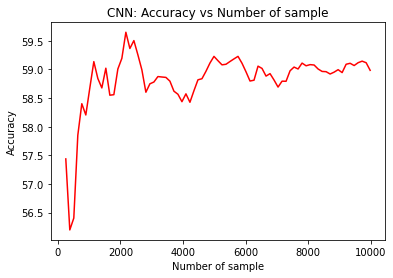

In [17]:
plot_accuracy(iteration_list, accuracy_list)

#Pruning


In [18]:
model_sgd_pruned = model_sgd

for name, module in model_sgd_pruned.named_modules():
    # prune 40% of connections in 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.4)
    # prune 40% of connections in linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)

print(dict(model_sgd_pruned.named_buffers()).keys())

dict_keys(['conv1.weight_mask', 'conv2.weight_mask', 'fc1.weight_mask', 'fc2.weight_mask', 'fc3.weight_mask'])


In [19]:
acc_model_sgd_pruned, accuracy_list, iteration_list = evaluate_model(test_data, model_sgd_pruned)
print('Accuracy: %.3f' % acc_model_sgd_pruned)

Accuracy: 0.537


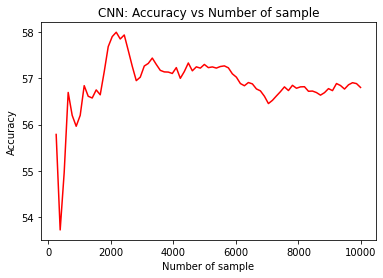

In [20]:
plot_accuracy(iteration_list, accuracy_list )

In [21]:
model_sgd_pruned_wr = model_sgd_pruned

# # train the model
train_model_SGD(train_data, model_sgd_pruned_wr)
# evaluate the model
acc_model_sgd_pruned_wr, accuracy_list, iteration_list = evaluate_model(test_data, model_sgd_pruned_wr)
print('Accuracy: %.3f' % acc_model_sgd_pruned_wr)

Accuracy: 0.597


In [22]:
model_sfw = model

constraints_list = create_k_sparse_constraints(model_sfw, 
        K=10, K_frac=0.05, value=15)


train_model_SFW(train_data, model_sfw, constraints_list)
# evaluate the model
acc_model_sfw, accuracy_list, iteration_list  = evaluate_model(test_data, model_sfw)
print('Accuracy: %.3f' % acc_model_sfw)

Accuracy: 0.551


In [23]:
model_sfw_pruned = model_sfw

for name, module in model_sfw_pruned.named_modules():
    # prune 40% of connections in 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.4)
    # prune 40% of connections in linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)

print(dict(model_sfw_pruned.named_buffers()).keys())

dict_keys(['conv1.weight_mask', 'conv2.weight_mask', 'fc1.weight_mask', 'fc2.weight_mask', 'fc3.weight_mask'])


In [24]:
acc_model_sfw_pruned, accuracy_list, iteration_list  = evaluate_model(test_data, model_sfw_pruned)
print('Accuracy: %.3f' % acc_model_sfw_pruned)

Accuracy: 0.538


In [25]:
model_sfw_pruned_wr = model_sfw_pruned

constraints_list = create_k_sparse_constraints(model_sfw_pruned_wr, 
        K=10, K_frac=0.05, value=15)
# # train the model
train_model_SFW(train_data, model_sfw_pruned_wr, constraints_list)
# evaluate the model
acc_model_sfw_pruned_wr, accuracy_list, iteration_list  = evaluate_model(test_data, model_sfw_pruned_wr)
print('Accuracy: %.3f' % acc_model_sfw_pruned_wr)

Accuracy: 0.547


# Model comparison

Our final results are also shown in the table below (the results may be slightly different due to a final run of the report)

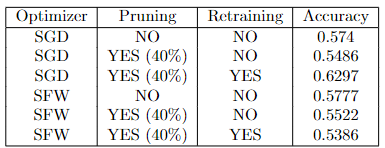

In [26]:
#Comparison between models

print('Optimizer: SGD, Pruning: NO, Retraining: NO   Accuracy:', acc_model_sgd)
print('Optimizer: SGD, Pruning: SI (40%), Retraining: NO   Accuracy:', acc_model_sgd_pruned)
print('Optimizer: SGD, Pruning: SI (40%), Retraining: SI   Accuracy:', acc_model_sgd_pruned_wr)
print('Optimizer: SFW, Pruning: NO, Retraining: NO   Accuracy:', acc_model_sfw)
print('Optimizer: SFW, Pruning: SI (40%), Retraining: NO   Accuracy:', acc_model_sfw_pruned)
print('Optimizer: SFW, Pruning: SI (40%), Retraining: SI   Accuracy:', acc_model_sfw_pruned_wr)

Optimizer: SGD, Pruning: NO, Retraining: NO   Accuracy: 0.5579
Optimizer: SGD, Pruning: SI (40%), Retraining: NO   Accuracy: 0.5371
Optimizer: SGD, Pruning: SI (40%), Retraining: SI   Accuracy: 0.5967
Optimizer: SFW, Pruning: NO, Retraining: NO   Accuracy: 0.5509
Optimizer: SFW, Pruning: SI (40%), Retraining: NO   Accuracy: 0.5379
Optimizer: SFW, Pruning: SI (40%), Retraining: SI   Accuracy: 0.5468
